Original code taken from https://medium.com/@aungkyawmyint_26195/multi-layer-perceptron-mnist-pytorch-463f795b897a

New things:
* Used a binary transformer with thresholding
* added functionality for switching between different artchitecutres

Other
* replaced some magic numbers with config variables
* Added variable to switch between architectures

In [1]:
#%%writefile -a mpc/setup_mnist.py
import torch
import numpy as np
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler
from config import *

from common import plot_batch
%matplotlib inline

# Settings

In [2]:
#%%writefile -a mpc/setup_mnist.py
#from models.mnist_binary_conf import * # load configuration file for model
use_dataset = "fashion" # "fashion" or "mnist"
if use_dataset == "fashion":
    from models.fashion_relu_conf import *
    from models.fashion_relu_conf import ReLUMLP as Net
    from mpc.setup_fashion import *
    
elif use_dataset == "mnist":
    from models.mnist_relu_conf import *
    from models.mnist_relu_conf import ReLUMLP as Net
    from mpc.setup_mnist import *

else:
    print("Invalid dataset chosen!")

# Data Preparation

In [22]:
# see mpc.setup_mnist.py or mpc.setup_fashion.py
print(f"number of train batches: {train_loader.dataset.data.shape[0] / train_loader.batch_size } of size {train_loader.batch_size}")
train_loader.dataset

number of train batches: 3000.0 of size 20


Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

In [21]:
print(f"number of test batches: {test_loader.dataset.data.shape[0] / test_loader.batch_size } of size {test_loader.batch_size}")
test_loader.dataset

number of test batches: 500.0 of size 20


Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

# Visualize a batch of training data

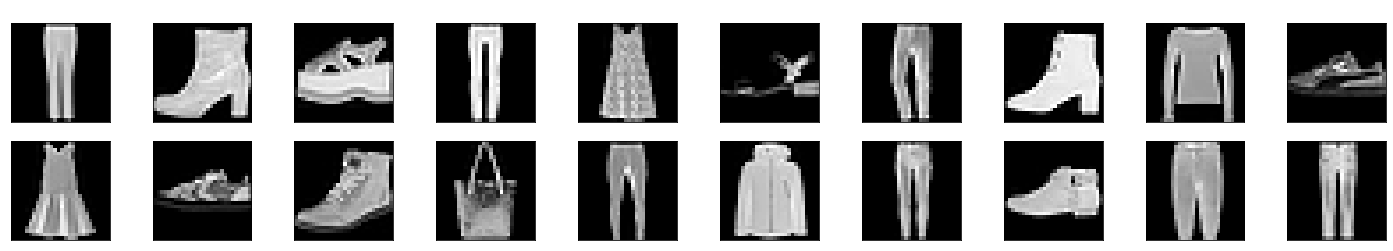

In [4]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
plot_batch(images, labels, label_color="white")

# Training

### Define Network Architecture

In [5]:
model = Net() # imported from conf
print(model)

ReLUMLP(
  (fc1): Linear(in_features=784, out_features=784, bias=True)
  (fc2): Linear(in_features=784, out_features=784, bias=True)
  (fc3): Linear(in_features=784, out_features=784, bias=True)
  (fc4): Linear(in_features=784, out_features=784, bias=True)
  (fc5): Linear(in_features=784, out_features=10, bias=True)
)


### Specify Loss function and Optimizer

In [6]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate = 0.01
optimizer = torch.optim.SGD(model.parameters(),lr = 0.01)

In [7]:
ENABLE_TRAIN = True
#ENABLE_TRAIN = False # So you can switch this off, if you want to rerun the entire notebook
#model_file_name = MODEL_DIR + "model_relu_peter.pth"# if you want to override where the model params are saved to!

if ENABLE_TRAIN:
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf  # set initial "min" to infinity
    for epoch in range(n_epochs):
        # monitor losses
        train_loss = 0
        valid_loss = 0


        ###################
        # train the model #
        ###################
        model.train() # prep model for training
        for data,label in train_loader:
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output,label)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update running training loss
            train_loss += loss.item() * data.size(0)


        ######################    
        # validate the model #
        ######################
        model.eval()  # prep model for evaluation
        for data,label in valid_loader:
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output,label)
            # update running validation loss 
            valid_loss = loss.item() * data.size(0)

        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = train_loss / len(train_loader.sampler)
        valid_loss = valid_loss / len(valid_loader.sampler)

        print("Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}".format(
            epoch+1, 
            train_loss,
            valid_loss
            ))

        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print("Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...".format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), model_file_name)
            valid_loss_min = valid_loss

    print("### --------- TRAINING DONE --------- ###")
else:
    print("### --------- DID NOT TRAIN --------- ###")
    print("Maybe you forgot to enable training for this notebook?")
    print("Check the top of this cell.")

Epoch: 1 	Training Loss: 0.841023 	Validation Loss: 0.000490
Validation loss decreased (inf --> 0.000490).  Saving model ...
Epoch: 2 	Training Loss: 0.443550 	Validation Loss: 0.000612
Epoch: 3 	Training Loss: 0.380425 	Validation Loss: 0.000517
Epoch: 4 	Training Loss: 0.346383 	Validation Loss: 0.000672
Epoch: 5 	Training Loss: 0.321087 	Validation Loss: 0.000297
Validation loss decreased (0.000490 --> 0.000297).  Saving model ...
### --------- TRAINING DONE --------- ###


In [11]:
print("Model is saved at:")
print(model_file_name)

Model is saved at:
/Users/peterholzner/Code/ML_2020/Ex3/models/model_fashion_relu.pt


# Test the trained Network

### Load the Model with Lowest Validation Loss

In [8]:
model.load_state_dict(torch.load(model_file_name))

<All keys matched successfully>

## Single party/standard variant

In [13]:
import time
from mpc.mpc_profile import *

In [14]:
# initialize lists to monitor test loss and accuracy
# NUM_CLASSES = 10

test_loss = 0.0
class_correct = [0] * NUM_CLASSES
class_total = [0] * NUM_CLASSES 

@profile
def train_model():
    model.eval() # prep model for evaluation
    for data, target in test_loader:
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update test loss 
        test_loss += loss.item()*data.size(0)
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)
        # compare predictions to true label
        correct = np.squeeze(pred.eq(target.data.view_as(pred)))
        # calculate test accuracy for each object class
        for i in range(len(target)):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

    # calculate and print avg test loss
    test_loss = test_loss/len(test_loader.sampler)
    print(f"Test Loss: {test_loss:.6}\n")
    # Print accuracy per class
    for i in range(NUM_CLASSES):
        if class_total[i] > 0:
            print(f"Test Accuracy of {i:5}: " 
                  f"{100 * class_correct[i] / class_total[i]:3.0f}% "
                  f"({np.sum(class_correct[i]):4} / {np.sum(class_total[i]):4} )")
        else:
            print(f"Test Accuracy of {classes[i]}: N/A (no training examples)")
    # Print overall accuracy
    print(f"\nTest Accuracy (Overall): {100. * np.sum(class_correct) / np.sum(class_total):3.0f}% "
          f"( {np.sum(class_correct)} / {np.sum(class_total)} )")

# Visualize Sample Test Results

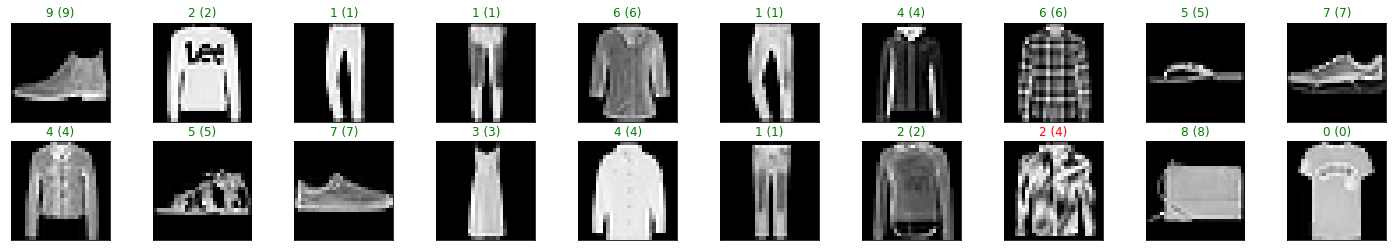

In [10]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)

plot_batch(images, labels, preds)